# HMM knockoffs

## fastPHASE HMM knockoffs

This is a tutorial for generating (fastPHASE) HMM knockoffs for [genome-wide association studies](https://en.wikipedia.org/wiki/Genome-wide_association_study). This kind of knockoffs is suitable for data *without* population admixture or cryptic relatedness. The methodology is described in the following paper:

> Sesia, Matteo, Chiara Sabatti, and Emmanuel J. Candès. "Gene hunting with hidden Markov model knockoffs." Biometrika 106.1 (2019): 1-18.

If your samples have diverse ancestries and/or extensive relatedness, we recommend those samples to be [filtered out](https://openmendel.github.io/SnpArrays.jl/latest/#SnpArrays.filter), or use SHAPEIT-HMM knockoffs.

In [1]:
# first load packages needed for this tutorial
using Revise
using SnpArrays
using Knockoffs
using Statistics
using Plots
using GLMNet
using Distributions
using Random
gr(fmt=:png);

## Step 0: Prepare example data

To illustrate we need example PLINK data, which are available in `Knockoffs.jl/data`

+ `test.(bed/bim/fam)` are simulated genotypes without missings
+ `mouse.imputed.(bed/bim/fam)` are real genotypes without missing

In [2]:
# Path to PLINK data
data_path = joinpath(normpath(Knockoffs.datadir()), "test")

"/Users/biona001/.julia/dev/Knockoffs/data/test"

## Step 1: Generate Knockoffs

Knockoffs are made using the wrapper function [hmm_knockoff](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.hmm_knockoff). This function does 3 steps sequentially:

1. Run fastPHASE on $\mathbf{X}_{n\times p}$ to estimate $\alpha, \theta, r$ (this step takes 5-10 min for the example data)
2. Fit and generate knockoff copies of the HMM 
3. Store knockoffs $\tilde{\mathbf{X}}_{n\times p}$ in binary PLINK format (by default under a new directory called `knockoffs`) and return it as a `SnpArray`

In [3]:
@time X̃ = hmm_knockoff(data_path, plink_outfile="test.fastphase.knockoffs")

seed = 1652154851

This is fastPHASE 1.4.8

Copyright 2005-2006.  University of Washington. All rights reserved.
Written by Paul Scheet, with algorithm developed by Paul Scheet and
Matthew Stephens in the Department of Statistics at the University of
Washington.  Please contact pscheet@alum.wustl.edu for questions, or to
obtain the software visit
http://stephenslab.uchicago.edu/software.html

Total proportion of missing genotypes: 0.000000
1000 diploids below missingness threshold, 0 haplotypes
 data read successfully
1000 diploid individuals, 10000 loci

K selected (by user): 		 12
seed: 			 1
no. EM starts: 		 1
EM iterations: 		 10
no. haps from posterior: 0
NOT using subpopulation labels


 this is random start no. 1 of 1 for the EM...

seed for this start: 1
-12448937.79229315
-9445075.64492578
-8349084.94704032
-7261896.43613014
-6281741.47324536
-5576823.19655063
-5155151.87406101
-4928193.53344398
-4802495.92350104
-4725979.88580363
final loglikelihood: -4676003.575106
iteratio



simulating 0 haplotypes from model: knockoffs/tmp1_hapsfrommodel.out
554.600068 seconds (124.71 M allocations: 6.023 GiB, 0.35% gc time, 4.53% compilation time)


1000×10000 SnpArray:
 0x00  0x00  0x02  0x03  0x02  0x02  …  0x03  0x03  0x03  0x02  0x03  0x02
 0x00  0x02  0x03  0x03  0x02  0x00     0x02  0x02  0x02  0x00  0x00  0x02
 0x00  0x00  0x02  0x03  0x02  0x02     0x03  0x03  0x00  0x00  0x02  0x02
 0x00  0x00  0x00  0x00  0x00  0x02     0x02  0x02  0x02  0x02  0x00  0x00
 0x00  0x00  0x02  0x02  0x02  0x02     0x02  0x00  0x00  0x00  0x03  0x03
 0x00  0x00  0x03  0x03  0x02  0x02  …  0x03  0x03  0x02  0x02  0x02  0x00
 0x00  0x00  0x03  0x03  0x00  0x03     0x03  0x00  0x02  0x02  0x03  0x03
 0x02  0x02  0x03  0x02  0x00  0x02     0x03  0x03  0x02  0x00  0x02  0x02
 0x02  0x00  0x02  0x02  0x00  0x02     0x03  0x03  0x02  0x02  0x00  0x03
 0x00  0x03  0x02  0x03  0x03  0x02     0x03  0x03  0x03  0x00  0x00  0x02
 0x00  0x02  0x02  0x03  0x03  0x02  …  0x03  0x03  0x03  0x03  0x00  0x02
 0x02  0x02  0x02  0x02  0x00  0x00     0x02  0x02  0x02  0x00  0x02  0x00
 0x00  0x00  0x03  0x03  0x02  0x02     0x02  0x02  0x02  0x00  0x00  0x00
    

### Optional parameters

Here are some optional parameters one can tune when fitting the HMM procedure. 

+ `K`: Number of haplotype clusters. Defaults to 12
+ `C`: Number of EM iterations before convergence. Defaults to 10.
+ `n`: Number of samples used to fit HMM in fastPHASE. Defaults to using all samples

They can be specified via:

```julia
@time X̃ = hmm_knockoff(
    data_file,
    plink_outfile="test.fastphase.knockoffs",
    K = 12,
    C = 10,
    n = 100)
```

## Step 2: Examine knockoff statistics

Lets check if the knockoffs "make sense". We will use [SnpArrays.jl](https://github.com/OpenMendel/SnpArrays.jl) to import the original and knockoff genotypes, and compare summary statistics using built-in functions [compare_pairwise_correlation](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_pairwise_correlation) and [compare_correlation](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.compare_correlation)

In [4]:
# import original and knockoff genotypes
X = SnpArray(data_path * ".bed")
X̃ = SnpArray("knockoffs/test.fastphase.knockoffs.bed")
n, p = size(X̃)

(1000, 10000)

Lets compare $cor(X_i, X_j)$ and $cor(X_i, \tilde{X}_j)$. If knockoffs satisfy exchangability, their correlation should be very similar and form a diagonal line. 

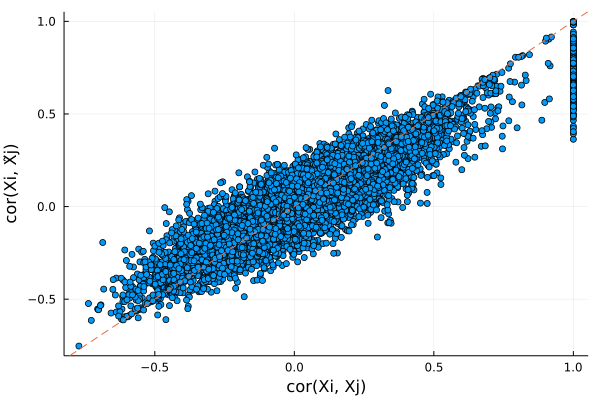

In [5]:
# look at only pairwise correlation between first 200 snps
r1, r2 = compare_pairwise_correlation(X, X̃, snps=200)

# make plot
scatter(r1, r2, xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)", legend=false)
Plots.abline!(1, 0, line=:dash)

Plots distribution of $cor(X_j, \tilde{X}_j)$ for all $j$. Ideally, we want $cor(X_j, \tilde{X}_j)$ to be small in magnitude (i.e. $X$ and $\tilde{X}$ is very different). Here the knockoffs are tightly correlated with the original genotypes, so they will likely have low power. 

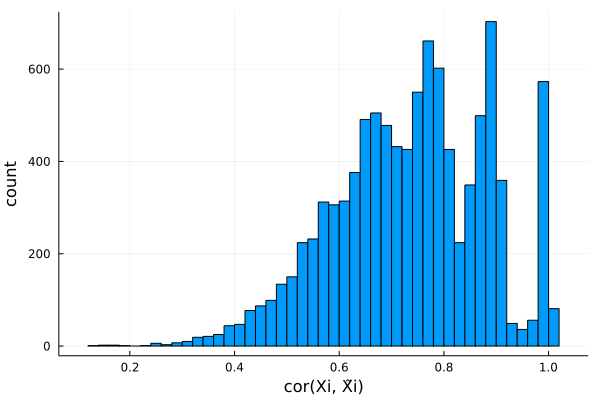

In [6]:
r2 = compare_correlation(X, X̃)
histogram(r2, legend=false, xlabel="cor(Xi, X̃i)", ylabel="count")

## LASSO example

Let us apply the generated knockoffs to the model selection problem
> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y}_{n \times 1} \sim N(\mathbf{X}_{n \times p}\mathbf{\beta}_{p \times 1} \ , \ \mathbf{\epsilon}_{n \times 1}), \quad \epsilon_i \sim N(0, 1)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [10]:
# set seed for reproducibility
Random.seed!(1111)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(k)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y
y = X * βtrue + randn(n)

1000-element Vector{Float64}:
 -7.523748950079584
 -5.870529819964483
 -0.5742132199848955
  2.1309132557501718
 -1.6879497296254022
  6.303519372510508
 -5.802636275728736
  4.326923276536526
 -1.0412802760571847
 -8.041827059609703
  5.499043516471697
 -7.052572319910739
 -0.7269822409994189
  ⋮
 -8.64616507915174
  9.75520485123946
 -4.741610543782101
  0.19476116174706148
 -6.907628164727042
  4.074654461857484
 -0.8816816975311048
 -4.477392544345892
 -0.9657429191845255
 -2.6017256381373777
  3.599329780486735
 -8.028131783786595

### Standard LASSO

Lets try running standard LASSO, which will produce $\hat{\mathbf{\beta}}_{p \times 1}$ where we typically declare SNP $j$ to be selected if $\hat{\beta}_j \ne 0$. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How well does LASSO perform in terms of power and FDR?

In [11]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)

#summarize
count(!iszero, βlasso), power, FDR

(348, 0.9, 0.8706896551724138)

Observe that

+ LASSO found a total of 348 SNPs
+ LASSO found $90$% of all true predictors
+ False discovery rate is 87%, meaning that 303/348 discovered predictors are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$

!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. 

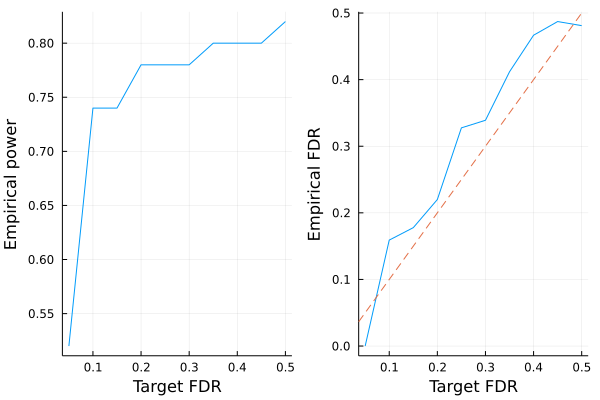

In [12]:
# interleave knockoffs with originals
Xfull, original, knockoff = merge_knockoffs_with_original(data_path,
    "knockoffs/test.fastphase.knockoffs",
    des="knockoffs/merged") 
Xfull = convert(Matrix{Float64}, Xfull, center=true, scale=true)

# step 1
knockoff_cv = glmnetcv(Xfull, y)                         # cross validation step
λbest = knockoff_cv.lambda[argmin(knockoff_cv.meanloss)] # find lambda that minimizes MSE
βestim = glmnet(Xfull, y, lambda=[λbest]).betas[:, 1]    # refit lasso with best lambda

# target FDR is 0.05, 0.1, ..., 0.5
FDR = collect(0.05:0.05:0.5)
empirical_power = Float64[]
empirical_fdr = Float64[]
for fdr in FDR
    βknockoff = extract_beta(βestim, fdr, original, knockoff) # steps 2-3 happen here

    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

Observe that

+ LASSO + knockoffs controls the false discovery rate at approximately the target (dashed line). If we repeat the simulation multiple times, the empirical FDR should average out to be slightly below the target level.
+ The power of LASSO + knockoffs is lower than standard LASSO
